# Weather Model Selection v2.0 - Complete Implementation

Implementasi lengkap mengikuti `training_guide_v2.md`:
- Cyclical Time Features (Sin/Cos)
- Interaction Features (Dew Point)
- Class Balancing (`class_weight='balanced'`)
- Expanding Window Cross-Validation
- Daily Model (agregasi + training)
- Visualisasi Januari 2022 (gap 2 hari)
- 7 File Model Output
- Multi-Step Forecasting

## 1. Persiapan Lingkungan

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR

try:
    from xgboost import XGBRegressor, XGBClassifier
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

import joblib
print(f"Libraries loaded | XGBoost: {XGBOOST_AVAILABLE}")

Libraries loaded | XGBoost: True


## 2. Load Data

In [21]:
DATA_PATH = '../data/historical_data_2000_2024.csv'
df = pd.read_csv(DATA_PATH)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp').reset_index(drop=True)
print(f"Dataset: {len(df):,} rows x {len(df.columns)} cols")
print(f"Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
df.head()

Dataset: 227,304 rows x 23 cols
Range: 2000-01-01 00:00:00 to 2025-12-05 23:00:00


,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,surface_pressure,weather_code,conditions,temp_max_daily,temp_min_daily,weather_code_daily,temp_mean_daily,humidity_avg_daily,pressure_avg_daily,windspeed_avg_daily
0,0,2000-01-01 00:00:00,0,1,1,2000,21.8,98,4.0,1008.4,...,984.5,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
1,1,2000-01-01 01:00:00,1,1,1,2000,21.4,99,4.0,1007.9,...,983.9,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
2,2,2000-01-01 02:00:00,2,1,1,2000,21.4,98,3.2,1007.4,...,983.4,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
3,3,2000-01-01 03:00:00,3,1,1,2000,21.2,99,4.6,1007.0,...,983.0,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3
4,4,2000-01-01 04:00:00,4,1,1,2000,21.0,99,3.6,1006.9,...,982.9,3,Overcast,27.5,20.8,53,24.1,91,1007.3,6.3


## 3. EDA (Exploratory Data Analysis)

### 3.1 Statistik Deskriptif

In [22]:
df.describe()

,id,timestamp,hour,day,month,year,temp,humidity,windspeed,sealevelpressure,...,apparent_temperature,surface_pressure,weather_code,temp_max_daily,temp_min_daily,weather_code_daily,temp_mean_daily,humidity_avg_daily,pressure_avg_daily,windspeed_avg_daily
count,227304.000000,227304,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,...,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000,227304.000000
mean,113651.500000,2012-12-18 11:30:00,11.500000,15.722733,6.507655,2012.465315,25.537435,79.351679,6.158908,1010.092567,...,29.415371,986.395679,17.317702,29.926291,22.183349,46.263858,25.528656,79.358568,1010.092334,6.160775
min,0.000000,2000-01-01 00:00:00,0.000000,1.000000,1.000000,2000.000000,17.000000,16.000000,0.000000,1002.200000,...,17.200000,978.700000,0.000000,23.300000,17.000000,0.000000,22.400000,40.000000,1004.600000,1.700000
25%,56825.750000,2006-06-25 17:45:00,5.750000,8.000000,4.000000,2006.000000,23.200000,71.000000,3.400000,1008.800000,...,27.100000,985.200000,2.000000,28.300000,21.500000,51.000000,24.500000,69.000000,1009.200000,4.300000
50%,113651.500000,2012-12-18 11:30:00,11.500000,16.000000,7.000000,2012.000000,25.000000,83.000000,5.200000,1010.200000,...,29.200000,986.400000,3.000000,29.500000,22.200000,55.000000,25.300000,84.000000,1010.200000,5.500000
75%,170477.250000,2019-06-13 05:15:00,17.250000,23.000000,9.000000,2019.000000,27.500000,93.000000,8.000000,1011.400000,...,31.500000,987.700000,51.000000,31.500000,23.000000,63.000000,26.500000,89.000000,1011.000000,7.200000
max,227303.000000,2025-12-05 23:00:00,23.000000,31.000000,12.000000,2025.000000,37.800000,100.000000,34.700000,1016.800000,...,40.500000,993.000000,65.000000,37.800000,25.400000,65.000000,30.400000,98.000000,1014.800000,26.900000
std,65617.157131,NaN,6.922202,8.802513,3.441529,7.482007,3.021772,16.929004,3.900788,1.867129,...,3.213625,1.793721,23.757623,2.317400,1.166040,23.501871,1.344515,11.826198,1.375177,2.657015


### 3.2 Distribusi Parameter Hourly

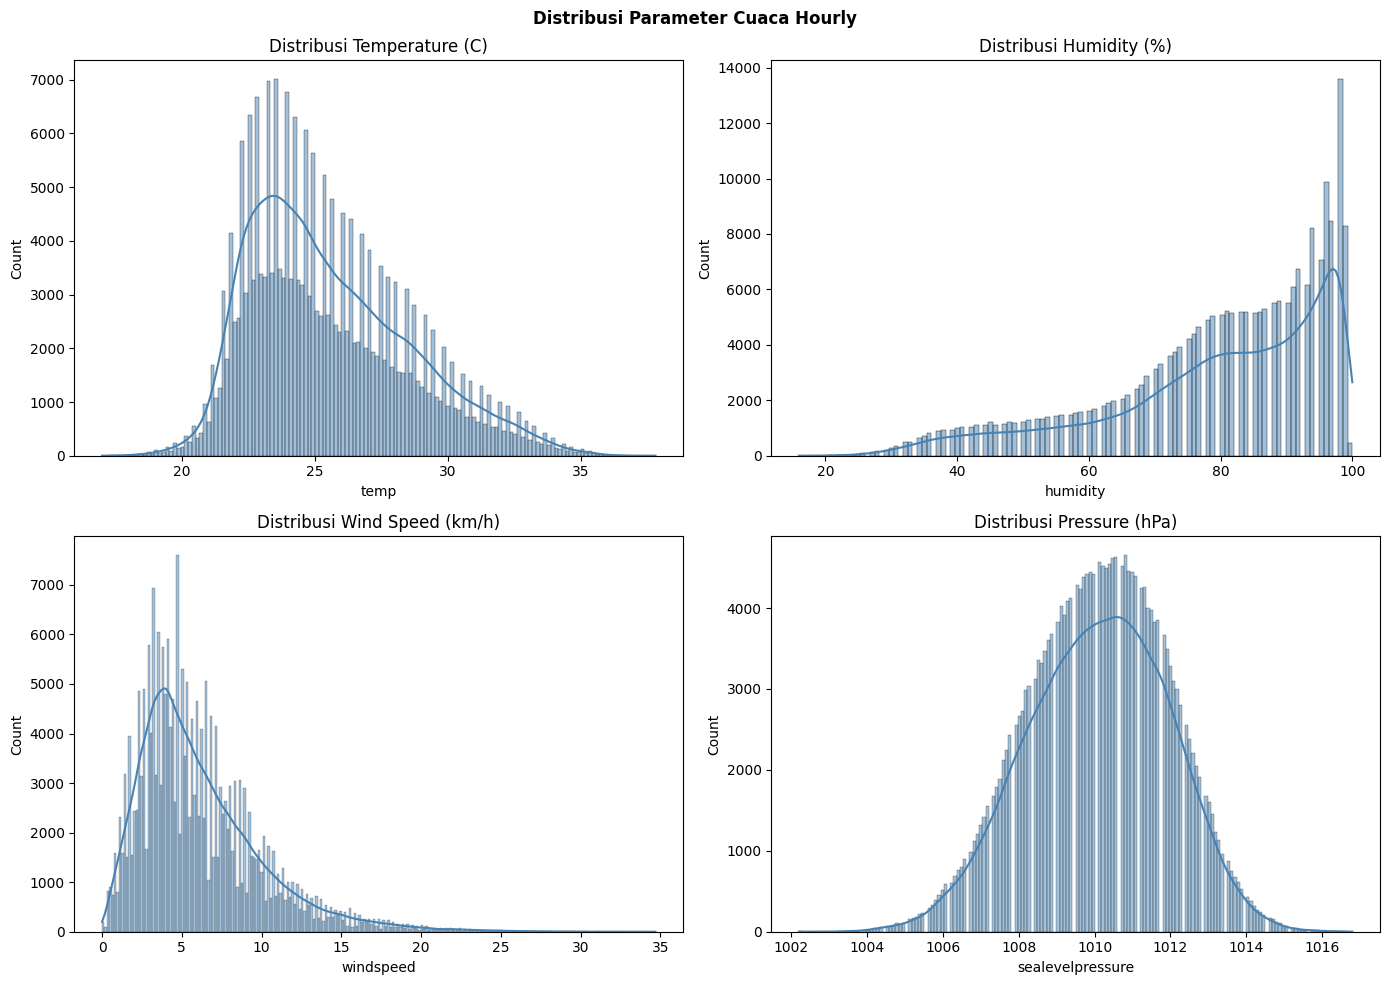

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
params = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
titles = ['Temperature (C)', 'Humidity (%)', 'Wind Speed (km/h)', 'Pressure (hPa)']
for ax, param, title in zip(axes.flatten(), params, titles):
    sns.histplot(df[param], kde=True, ax=ax, color='steelblue')
    ax.set_title(f'Distribusi {title}')
plt.suptitle('Distribusi Parameter Cuaca Hourly', fontweight='bold')
plt.tight_layout()
plt.show()

### 3.3 Korelasi Heatmap

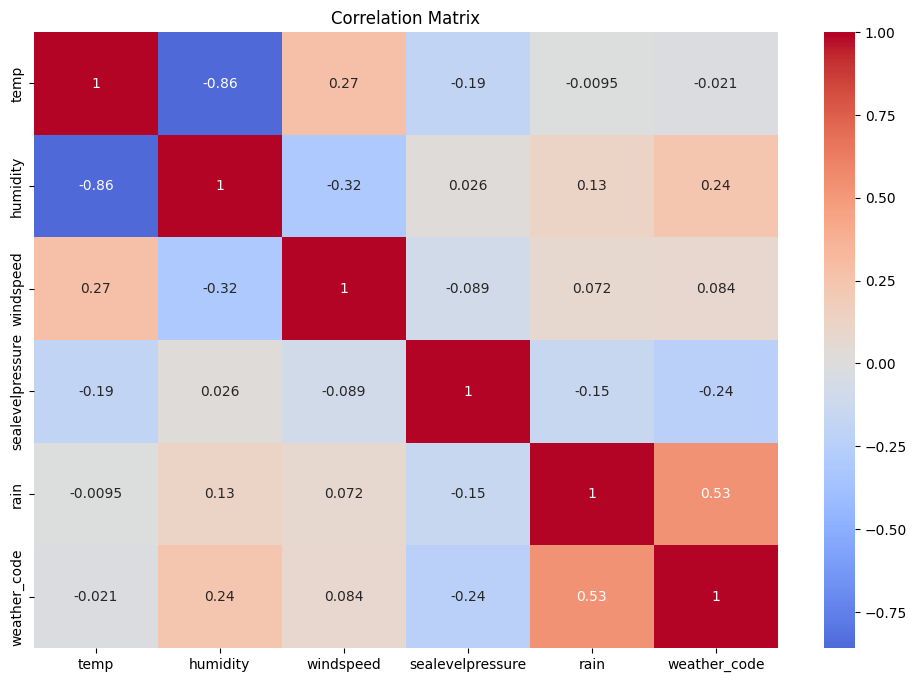

In [24]:
plt.figure(figsize=(12, 8))
cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure', 'rain', 'weather_code']
sns.heatmap(df[cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

### 3.4 Weather Code vs Rain

In [25]:
df.groupby('weather_code')[['rain']].agg(['mean', 'count'])

rain       
                   mean  count
weather_code                  
0              0.000000  23299
1              0.000000  28622
2              0.000000  26366
3              0.000000  81996
51             0.205187  37111
53             0.661253  12419
55             1.091673   3783
61             1.743208   7332
63             3.948567   5792
65            10.288356    584

## 4. Feature Engineering

### 4.1 Label Encoding

In [26]:
df_hourly = df.copy()
le_conditions = LabelEncoder()
df_hourly['conditions_encoded'] = le_conditions.fit_transform(df_hourly['conditions'])
le_weather_code = LabelEncoder()
df_hourly['weather_code_encoded'] = le_weather_code.fit_transform(df_hourly['weather_code'])
print("Label encoding done")

Label encoding done


### 4.2 [v2.0] Cyclical Time Features

In [27]:
df_hourly['hour_sin'] = np.sin(2 * np.pi * df_hourly['hour'] / 24)
df_hourly['hour_cos'] = np.cos(2 * np.pi * df_hourly['hour'] / 24)
df_hourly['month_sin'] = np.sin(2 * np.pi * df_hourly['month'] / 12)
df_hourly['month_cos'] = np.cos(2 * np.pi * df_hourly['month'] / 12)
df_hourly['day_of_year'] = df_hourly['timestamp'].dt.dayofyear
df_hourly['doy_sin'] = np.sin(2 * np.pi * df_hourly['day_of_year'] / 365)
df_hourly['doy_cos'] = np.cos(2 * np.pi * df_hourly['day_of_year'] / 365)
print("Cyclical features created")

Cyclical features created


### 4.3 [v2.0] Interaction Features

In [30]:
df_hourly['dew_point'] = df_hourly['temp'] - ((100 - df_hourly['humidity']) / 5)
df_hourly['temp_range'] = df_hourly['temp_max_daily'].shift(24) - df_hourly['temp_min_daily'].shift(24)
df_hourly['humid_temp_ratio'] = df_hourly['humidity'] / (df_hourly['temp'] + 1)
print("Interaction features created")

Interaction features created


### 4.4 Lag Features Hourly

In [31]:
cols = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
for col in cols:
    df_hourly[f'{col}_lag_1'] = df_hourly[col].shift(1)
    df_hourly[f'{col}_lag_24'] = df_hourly[col].shift(24)
    df_hourly[f'{col}_rolling_24'] = df_hourly[col].rolling(24).mean()
    df_hourly[f'{col}_rolling_3'] = df_hourly[col].rolling(3).mean()
    df_hourly[f'{col}_rolling_6'] = df_hourly[col].rolling(6).mean()
    df_hourly[f'{col}_rolling_std_24'] = df_hourly[col].rolling(24).std()

df_hourly = df_hourly.dropna().reset_index(drop=True)
print(f"Hourly: {len(df_hourly):,} rows after dropna")

Hourly: 227,280 rows after dropna


### 4.5 [v2.0] Preprocessing Data Daily

In [32]:
# Agregasi hourly ke daily
df_daily = df.groupby(['year', 'month', 'day']).agg({
    'temp': ['min', 'max', 'mean'],
    'humidity': 'mean',
    'windspeed': 'mean',
    'sealevelpressure': 'mean',
    'weather_code': lambda x: x.mode()[0],
    'rain': 'sum'
}).reset_index()

df_daily.columns = ['year', 'month', 'day', 'temp_min', 'temp_max', 'temp_mean',
                    'humidity_avg', 'windspeed_avg', 'pressure_avg',
                    'weather_code_dominant', 'rain_total']

le_weather_code_daily = LabelEncoder()
df_daily['weather_code_dominant_encoded'] = le_weather_code_daily.fit_transform(df_daily['weather_code_dominant'])
print(f"Daily: {len(df_daily):,} rows")

Daily: 9,471 rows


### 4.6 [v2.0] Lag Features Daily dengan Rolling 3d/7d

In [33]:
# Lag 1 day
for col in ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg']:
    df_daily[f'{col}_lag_1'] = df_daily[col].shift(1)

# Lag 7 days
df_daily['temp_min_lag_7'] = df_daily['temp_min'].shift(7)
df_daily['temp_max_lag_7'] = df_daily['temp_max'].shift(7)
df_daily['temp_mean_lag_7'] = df_daily['temp_mean'].shift(7)
df_daily['rain_total_lag_1'] = df_daily['rain_total'].shift(1)

# Rolling 3d/7d
df_daily['temp_rolling_3d'] = df_daily['temp_mean'].rolling(3).mean()
df_daily['temp_rolling_7d'] = df_daily['temp_mean'].rolling(7).mean()
df_daily['humidity_rolling_3d'] = df_daily['humidity_avg'].rolling(3).mean()
df_daily['humidity_rolling_7d'] = df_daily['humidity_avg'].rolling(7).mean()

df_daily = df_daily.dropna().reset_index(drop=True)
print(f"Daily after features: {len(df_daily):,} rows")

Daily after features: 9,464 rows


## 5. Model Training

### 5.1 [v2.0] Expanding Window Cross-Validation Function

In [34]:
tscv = TimeSeriesSplit(n_splits=5)

def evaluate_with_cv(model, X, y):
    """Evaluasi dengan Time Series Cross-Validation"""
    scores = {'r2': [], 'rmse': []}
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores['r2'].append(r2_score(y_test, y_pred))
        scores['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
    return {'R2_mean': np.mean(scores['r2']), 'R2_std': np.std(scores['r2']), 'RMSE_mean': np.mean(scores['rmse'])}

print("CV function ready")

CV function ready


### 5.2 Data Split (HOURLY)

In [35]:
# Features Hourly
hourly_feature_cols = [
    'hour_sin', 'hour_cos', 'month_sin', 'month_cos',
    'temp_lag_1', 'temp_lag_24', 'temp_rolling_24', 'temp_rolling_3', 'temp_rolling_6',
    'humidity_lag_1', 'humidity_lag_24', 'humidity_rolling_24', 'humidity_rolling_3', 'humidity_rolling_6',
    'windspeed_lag_1', 'windspeed_lag_24', 'windspeed_rolling_24', 'windspeed_rolling_3', 'windspeed_rolling_6',
    'sealevelpressure_lag_1', 'sealevelpressure_lag_24', 'sealevelpressure_rolling_24', 'sealevelpressure_rolling_3', 'sealevelpressure_rolling_6',
    'dew_point', 'humid_temp_ratio'
]
hourly_target_reg = ['temp', 'humidity', 'windspeed', 'sealevelpressure']
hourly_target_clf = 'weather_code_encoded'

train_size = int(len(df_hourly) * 0.8)
hourly_train = df_hourly[:train_size]
hourly_test = df_hourly[train_size:]

X_hourly_train = hourly_train[hourly_feature_cols]
X_hourly_test = hourly_test[hourly_feature_cols]
y_hourly_train_reg = hourly_train[hourly_target_reg]
y_hourly_test_reg = hourly_test[hourly_target_reg]
y_hourly_train_clf = hourly_train[hourly_target_clf]
y_hourly_test_clf = hourly_test[hourly_target_clf]

print(f"Hourly Train: {len(X_hourly_train):,} | Test: {len(X_hourly_test):,}")

Hourly Train: 181,824 | Test: 45,456


### 5.3 Data Split (DAILY)

In [36]:
# Features Daily
daily_feature_cols = [
    'month', 'day',
    'temp_min_lag_1', 'temp_max_lag_1', 'temp_mean_lag_1',
    'humidity_avg_lag_1', 'windspeed_avg_lag_1', 'pressure_avg_lag_1',
    'temp_min_lag_7', 'temp_max_lag_7', 'temp_mean_lag_7',
    'rain_total_lag_1',
    'temp_rolling_3d', 'temp_rolling_7d',
    'humidity_rolling_3d', 'humidity_rolling_7d'
]
daily_target_reg = ['temp_min', 'temp_max', 'temp_mean', 'humidity_avg', 'windspeed_avg', 'pressure_avg']
daily_target_clf = 'weather_code_dominant_encoded'

daily_train_size = int(len(df_daily) * 0.8)
daily_train = df_daily[:daily_train_size]
daily_test = df_daily[daily_train_size:]

X_daily_train = daily_train[daily_feature_cols]
X_daily_test = daily_test[daily_feature_cols]
y_daily_train_reg = daily_train[daily_target_reg]
y_daily_test_reg = daily_test[daily_target_reg]
y_daily_train_clf = daily_train[daily_target_clf]
y_daily_test_clf = daily_test[daily_target_clf]

print(f"Daily Train: {len(X_daily_train):,} | Test: {len(X_daily_test):,}")

Daily Train: 7,571 | Test: 1,893


### 5.4 Regression Models (HOURLY)

In [37]:
regression_models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    regression_models['XGBoost Regressor'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {'MSE': mse, 'RMSE': np.sqrt(mse), 'MAE': mean_absolute_error(y_true, y_pred), 'R2': r2_score(y_true, y_pred)}

reg_results = []
for name, model in regression_models.items():
    print(f"Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_reg)
    y_pred = model.predict(X_hourly_test)
    metrics = evaluate_regression(y_hourly_test_reg, y_pred)
    metrics['Model'] = name
    reg_results.append(metrics)

df_hourly_reg = pd.DataFrame(reg_results).sort_values('R2', ascending=False)
display(df_hourly_reg[['Model', 'R2', 'RMSE', 'MAE']])
best_hourly_reg_name = df_hourly_reg.iloc[0]['Model']
print(f"Best Hourly Regression: {best_hourly_reg_name}")

Training Linear Regression...
Training K-Neighbors Regressor...
Training Decision Tree Regressor...
Training Random Forest Regressor...
Training XGBoost Regressor...


,Model,R2,RMSE,MAE
4,XGBoost Regressor,0.973863,0.700147,0.359699
0,Linear Regression,0.968570,0.983155,0.603512
3,Random Forest Regressor,0.945558,0.891854,0.515611
1,K-Neighbors Regressor,0.888599,1.927346,1.237030
2,Decision Tree Regressor,0.853477,1.303800,0.936126


Best Hourly Regression: XGBoost Regressor


### 5.5 [v2.0] Classification with Class Balancing (HOURLY)

In [42]:
classification_models = {
    'Logistic Regression Balanced': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest Classifier Balanced': RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    classification_models['XGBoost Classifier'] = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

clf_results = []
for name, model in classification_models.items():
    print(f"Training {name}...")
    model.fit(X_hourly_train, y_hourly_train_clf)
    y_pred = model.predict(X_hourly_test)
    clf_results.append({'Model': name, 'Accuracy': accuracy_score(y_hourly_test_clf, y_pred), 
                        'F1': f1_score(y_hourly_test_clf, y_pred, average='weighted', zero_division=0)})

df_hourly_clf = pd.DataFrame(clf_results).sort_values('Accuracy', ascending=False)
display(df_hourly_clf)
best_hourly_clf_name = df_hourly_clf.iloc[0]['Model']
print(f"Best Hourly Classification: {best_hourly_clf_name}")

Training Logistic Regression Balanced...
Training Logistic Regression...
Training Decision Tree Classifier...
Training Random Forest Classifier Balanced...
Training Random Forest Classifier...
Training XGBoost Classifier...


,Model,Accuracy,F1
5,XGBoost Classifier,0.457079,0.416321
4,Random Forest Classifier,0.451602,0.408144
1,Logistic Regression,0.432396,0.366741
2,Decision Tree Classifier,0.426148,0.390207
3,Random Forest Classifier Balanced,0.329373,0.339975
0,Logistic Regression Balanced,0.271251,0.286111


Best Hourly Classification: XGBoost Classifier


### 5.6 Regression Models (DAILY)

In [39]:
# Re-initialize models
daily_reg_models = {
    'Linear Regression': LinearRegression(),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42, max_depth=10),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    daily_reg_models['XGBoost Regressor'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

daily_reg_results = []
for name, model in daily_reg_models.items():
    print(f"Training Daily {name}...")
    model.fit(X_daily_train, y_daily_train_reg)
    y_pred = model.predict(X_daily_test)
    metrics = evaluate_regression(y_daily_test_reg, y_pred)
    metrics['Model'] = name
    daily_reg_results.append(metrics)

df_daily_reg = pd.DataFrame(daily_reg_results).sort_values('R2', ascending=False)
display(df_daily_reg[['Model', 'R2', 'RMSE', 'MAE']])
best_daily_reg_name = df_daily_reg.iloc[0]['Model']
print(f"Best Daily Regression: {best_daily_reg_name}")

Training Daily Linear Regression...
Training Daily K-Neighbors Regressor...
Training Daily Decision Tree Regressor...
Training Daily Random Forest Regressor...
Training Daily XGBoost Regressor...


,Model,R2,RMSE,MAE
0,Linear Regression,0.773614,1.498718,0.902293
4,XGBoost Regressor,0.728211,1.589738,0.967316
3,Random Forest Regressor,0.684684,1.624549,1.018101
1,K-Neighbors Regressor,0.485718,1.940664,1.246611
2,Decision Tree Regressor,0.477612,2.029317,1.268789


Best Daily Regression: Linear Regression


### 5.7 Classification (DAILY)

In [43]:
daily_clf_models = {
    'Logistic Regression Balanced': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state=42, max_depth=10),
    'Random Forest Classifier Balanced': RandomForestClassifier(n_estimators=100, class_weight='balanced', max_depth=10, min_samples_leaf=5, random_state=42, n_jobs=-1),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
}
if XGBOOST_AVAILABLE:
    daily_clf_models['XGBoost Classifier'] = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

daily_clf_results = []
for name, model in daily_clf_models.items():
    print(f"Training Daily {name}...")
    model.fit(X_daily_train, y_daily_train_clf)
    y_pred = model.predict(X_daily_test)
    daily_clf_results.append({'Model': name, 'Accuracy': accuracy_score(y_daily_test_clf, y_pred),
                              'F1': f1_score(y_daily_test_clf, y_pred, average='weighted', zero_division=0)})

df_daily_clf = pd.DataFrame(daily_clf_results).sort_values('Accuracy', ascending=False)
display(df_daily_clf)
print(f"Best Daily Classification: {df_daily_clf.iloc[0]['Model']}")

Training Daily Logistic Regression Balanced...
Training Daily Logistic Regression...
Training Daily Decision Tree Classifier...
Training Daily Random Forest Classifier Balanced...
Training Daily Random Forest Classifier...
Training Daily XGBoost Classifier...


,Model,Accuracy,F1
1,Logistic Regression,0.650819,0.573684
4,Random Forest Classifier,0.624406,0.555213
5,XGBoost Classifier,0.584786,0.559720
2,Decision Tree Classifier,0.505547,0.507064
3,Random Forest Classifier Balanced,0.445325,0.492259
0,Logistic Regression Balanced,0.253038,0.281595


Best Daily Classification: Logistic Regression
